In [2]:
'''
import time
import os
import sys
import numpy as np
from fast_histogram import histogram1d, histogram2d
import matplotlib as mpl
#mpl.use('agg')
#import hmf
from Functions import Functions as F
import multiprocessing
from numba import jit
from colossus.cosmology import cosmology
from colossus.halo.mass_defs import changeMassDefinition as CMD
from colossus.halo.mass_defs import pseudoEvolve as PE
from colossus.lss import mass_function
from colossus.halo.concentration import concentration as get_c
from colossus.halo.mass_so import M_to_R
from scipy.interpolate import interp1d
from halotools import empirical_models
from astropy.cosmology import Planck15 as Cosmo_AstroPy
plt = mpl.pyplot
plt.ion(); plt.show()
T1 = time.time()
cosmology.setCosmology("planck15")
Cosmo = cosmology.getCurrent()
h = Cosmo.h
h_3 = h*h*h

#Get the HMF (Halo Mass Function) according to Murray et al. 2013
#https://arxiv.org/abs/1306.6721
#HMF_fun = F.Make_HMF_Interp()

#set to True for better HM/SM resolution, takes MUCH longer
HighRes = False

#Cuts in Satellite mass
SM_Cuts = [9, 9.5, 10, 10.5, 11, 11.45]#[9,10,11]#
#When using Abundance matching do N realisations to capture upscatter effects
N = 5

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': True,\
'B18c':True,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters_Glob = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}


#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
'''

'\nimport time\nimport os\nimport sys\nimport numpy as np\nfrom fast_histogram import histogram1d, histogram2d\nimport matplotlib as mpl\n#mpl.use(\'agg\')\n#import hmf\nfrom Functions import Functions as F\nimport multiprocessing\nfrom numba import jit\nfrom colossus.cosmology import cosmology\nfrom colossus.halo.mass_defs import changeMassDefinition as CMD\nfrom colossus.halo.mass_defs import pseudoEvolve as PE\nfrom colossus.lss import mass_function\nfrom colossus.halo.concentration import concentration as get_c\nfrom colossus.halo.mass_so import M_to_R\nfrom scipy.interpolate import interp1d\nfrom halotools import empirical_models\nfrom astropy.cosmology import Planck15 as Cosmo_AstroPy\nplt = mpl.pyplot\nplt.ion(); plt.show()\nT1 = time.time()\ncosmology.setCosmology("planck15")\nCosmo = cosmology.getCurrent()\nh = Cosmo.h\nh_3 = h*h*h\n\n#Get the HMF (Halo Mass Function) according to Murray et al. 2013\n#https://arxiv.org/abs/1306.6721\n#HMF_fun = F.Make_HMF_Interp()\n\n#set to T

In [3]:
'''
#Calculate Halo Mass (z), van den Bosch

#HaloMass Limits and Bins
AnalyticHaloMass_min = 11.0; AnalyticHaloMass_max = 16.6
if HighRes:
    AnalyticHaloBin = 0.05
else:
    AnalyticHaloBin = 0.1
#AHB_2 = AnalyticHaloBin*AnalyticHaloBin #Not used
AnalyticHaloMass = np.arange(AnalyticHaloMass_min + np.log10(h), AnalyticHaloMass_max + np.log10(h), AnalyticHaloBin) #Create array in the Halo Mass range
#Units are in M_virial * h^-1
#Read https://arxiv.org/abs/1308.4150

#This is the Halomass growth history
#Generates redshfit steps that are small enough to avoid systematics.
z, AvaHaloMass_wz = F.Get_HM_History(AnalyticHaloMass, AnalyticHaloMass_min, AnalyticHaloMass_max, AnalyticHaloBin)
AvaHaloMass = AvaHaloMass_wz[:, 1:] #Avarage Halo Mass for each redshift (M,N), units of [log10 Msun]

#Account for central bin shrinking
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
'''

'\n#Calculate Halo Mass (z), van den Bosch\n\n#HaloMass Limits and Bins\nAnalyticHaloMass_min = 11.0; AnalyticHaloMass_max = 16.6\nif HighRes:\n    AnalyticHaloBin = 0.05\nelse:\n    AnalyticHaloBin = 0.1\n#AHB_2 = AnalyticHaloBin*AnalyticHaloBin #Not used\nAnalyticHaloMass = np.arange(AnalyticHaloMass_min + np.log10(h), AnalyticHaloMass_max + np.log10(h), AnalyticHaloBin) #Create array in the Halo Mass range\n#Units are in M_virial * h^-1\n#Read https://arxiv.org/abs/1308.4150\n\n#This is the Halomass growth history\n#Generates redshfit steps that are small enough to avoid systematics.\nz, AvaHaloMass_wz = F.Get_HM_History(AnalyticHaloMass, AnalyticHaloMass_min, AnalyticHaloMass_max, AnalyticHaloBin)\nAvaHaloMass = AvaHaloMass_wz[:, 1:] #Avarage Halo Mass for each redshift (M,N), units of [log10 Msun]\n\n#Account for central bin shrinking\nAvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] \nAvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T),

In [143]:
'''
HM_vdB = AvaHaloMass
HM_vdB_Bins = AvaHaloMassBins
z_vdB = z
'''

In [4]:
'''
plt.figure()
for i in range(0,HM_vdB[0,:].size):
    plt.semilogx(z_vdB, HM_vdB[:,i])
plt.xlim(0.1,4)
'''

'\nplt.figure()\nfor i in range(0,HM_vdB[0,:].size):\n    plt.semilogx(z_vdB, HM_vdB[:,i])\nplt.xlim(0.1,4)\n'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import time
import sys

In [2]:
#### Identify index of a desired redshift value
def identify_idx_z(z_desired, z):
    if (z_desired == 0.):
        z_idx=0
    elif (z_desired > 0. and z_desired < np.max(z)):
        for i in range(0,z.size):
            if (z[i]>z_desired):
                z_idx=i
                break
        z2=z[z_idx]; z1=z[z_idx-1]
        diff1=np.abs(z1-z_desired)
        diff2=np.abs(z2-z_desired)
        if (diff1<=diff2):
            z_idx=z_idx-1
    #elif (z_desired == 6.):
        #z_idx=z.size-1
    elif (z_desired > np.max(z)):
        Err_msg = 'The desired value {} in z_desired is larger than the maximum value in z!\nCannot identify z index!'.format(z_desired)
        sys.exit(Err_msg)
    return z_idx


#### Build the list of desired redshifts
def build_z_desired(z_min, z_max, z_bin):
    z_desired = []
    z_prova = z_min
    z_desired.append(z_prova)
    while True:
        z_prova += z_bin
        if (z_prova>z_max):
            break
        z_desired.append(z_prova)
    return z_desired


#### Find index for Behroozi HM, given HM_vdB, and Behroozi HM array
def identify_idx_HM(HM_vdB, HM):
    if (HM_vdB <= np.min(HM)):
        HM_idx=0
    elif (HM_vdB > np.min(HM) and HM_vdB < np.max(HM)):
        for i in range(0,HM.size):
            if (HM[i]>HM_vdB):
                HM_idx=i
                break
        HM2=HM[HM_idx]; HM1=HM[HM_idx-1]
        diff1=np.abs(HM1-HM_vdB)
        diff2=np.abs(HM2-HM_vdB)
        if (diff1<=diff2):
            HM_idx=HM_idx-1
    #elif (z_desired == 6.):
        #z_idx=z.size-1
    elif (HM_vdB > np.max(HM)):
        HM_idx=HM.size
        if (np.abs(HM_vdB-np.max(HM)) >.1):
            Err_msg = 'The desired value {} of HM_vdB is much larger than the maximum value in HM Behroozi!\nCannot identify HM index!'.format(HM_vdB)
            sys.exit(Err_msg)
    return HM_idx
        

In [12]:
#Get SMHM from catalog, Behroozi

#path = 'Behroozi_SFR_ASCII/'
#file_name = 'sfr_catalog_0.994717.txt'
#data = pd.read_table(path+file_name, header = None)

In [3]:
#path = 'Behroozi_SFR_ASCII/'
file_names_prov = []
#os.chdir("")
for found_name in glob.glob("*sfr_catalog_*"):
    file_names_prov.append(found_name)

In [4]:
a = np.zeros(len(file_names_prov))
for i in range(0,a.size):
    a[i] = float(file_names_prov[i][12:20])
z = 1./a -1.
idx = np.argsort(z)
z = np.sort(z)
file_names = []
for i in range(0, idx.size):
    file_names.append(file_names_prov[idx[i]])

In [97]:
#x = pd.read_csv('sfr_catalog_0.994717.txt', skiprows=np.arange(0,30,1), sep=' ', usecols=['M','SM/HM'])
# index_col=False, names=['HM','SMHM'],, names=np.arange(0,26,1)

In [99]:
#SMHM=x.loc[:,'SM/HM'].values
#x['M']

In [11]:
data = []
HM = []
SMHM = []
SM = []
obs_SM = []
z_desired = build_z_desired(0.2, 4.1, 0.4)
z_idx = []
for z_des in z_desired:
    z_idx.append(identify_idx_z(z_des, z))
#'''
t0=time.time()
time_list = []
k=0
for i in range(0,len(z_idx)):
    print('loading file for z = {}'.format(z[z_idx[i]]))
    #HM=np.append(np.loadtxt(file_names[i], usecols=11))
    data.append(pd.read_csv(file_names[z_idx[i]], skiprows=np.arange(0,30,1), sep=' ', usecols=['M','SM/HM']))
    HM.append(data[i].loc[:,'M'].values)
    #SM.append(data[i].loc[:,'SM'].values)
    #obs_SM.append(data[i].loc[:,'obs_SM'].values)
    SMHM.append(data[i].loc[:,'SM/HM'].values)
    
    #data = pd.read_csv(file_names[i], '\t', header = None)
    k+=1
    time_list.append(time.time()-t0)
    time_array=np.array(time_list)
    remaining_time_min = int((len(z_idx)-k-1.)*np.mean(time_array)/60.)
    remaining_time_s = np.mod((len(z_idx)-k-1.)*np.mean(time_array),60)
    print('Time used = {:0.2f} s, estimated remaining time = {} min {:0.2f} s'.format(time.time()-t0, remaining_time_min, remaining_time_s))
    t0=time.time()
    
#'''

loading file for z = 0.186461994063
Time used = 78.89 s, estimated remaining time = 72 min 18.81 s
loading file for z = 0.593155802672
Time used = 115.32 s, estimated remaining time = 87 min 23.54 s
loading file for z = 1.01588517518
Time used = 131.93 s, estimated remaining time = 96 min 1.74 s
loading file for z = 1.4092902231
Time used = 140.18 s, estimated remaining time = 101 min 2.08 s
loading file for z = 1.78263192458
Time used = 148.78 s, estimated remaining time = 104 min 33.98 s
loading file for z = 2.18664159842
Time used = 152.62 s, estimated remaining time = 106 min 37.61 s
loading file for z = 2.59230241439
Time used = 147.93 s, estimated remaining time = 106 min 49.51 s
loading file for z = 3.03229058299
Time used = 154.31 s, estimated remaining time = 106 min 59.72 s
loading file for z = 3.39081792156
Time used = 150.20 s, estimated remaining time = 106 min 11.85 s
loading file for z = 3.81932355975
Time used = 145.60 s, estimated remaining time = 104 min 42.41 s


In [8]:
#print(1./(1.+2.))
#print(1./(1.+z[z_idx]))
#print(z[z_idx])
#print(z_desired)
#k = pd.read_csv('sfr_catalog_0.455560.txt', skiprows=np.arange(0,30,1), sep=' ', usecols=['M','SM/HM'])

In [29]:
#Convert HM from [M_sun] to [log10 M_sun]
#for i in range(0, len(HM)):
    #HM[i] = np.log10(HM[i])

In [12]:
z_vdB = np.loadtxt('Redshift_array.txt')
HM_vdB = np.loadtxt('HM_vdB.dat')

(0.1, 4)

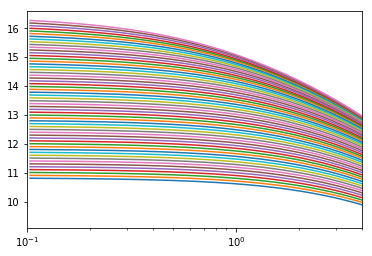

In [43]:
plt.figure()
for i in range(0,HM_vdB[0,:].size):
    plt.semilogx(z_vdB, HM_vdB[:,i])
plt.xlim(0.1,4)

In [20]:
HM_vdB.shape

(190, 57)

In [13]:
z_idx_vdB = []
for z_des in z_desired:
    z_idx_vdB.append(identify_idx_z(z_des, z_vdB))

In [14]:
SM_Beh = []
#HM_0_desired = [10., 10.5, 11.]
#HM_0_index = []
k=0
t0=time.time()
time_list = []
for HM_0 in HM_vdB[0,:]: #range(0,len(HM_0_desired)):
    print('Running for log10(HM_0) = {}, {} out of 57'.format(HM_0,k+1))
    idx_HM = identify_idx_HM(HM_0, np.log10(HM[0]))
    if (SMHM[0][idx_HM]*10.**HM_0 < 10.**11.5):
        SM_Beh.append(np.zeros(len(z_desired)))
        for j in range(0,len(z_desired)):
            idx_HM = identify_idx_HM(HM_0, np.log10(HM[j]))
            #HM_Beh[i][j] = HM[j][idx_HM]
            SM_Beh[k][j] = SMHM[j][idx_HM]*10.**HM_0 #[M_sun]
            #HM_Beh[k][j] = np.log10(HM_Beh[k][j]) #[log10 M_sun]
    k+=1
    time_list.append(time.time()-t0)
    time_array=np.array(time_list)
    remaining_time_min = int((57.-k-1.)*np.mean(time_array)/60.)
    remaining_time_s = np.mod((57.-k-1.)*np.mean(time_array),60)
    print('Time used = {:0.2f} s, estimated remaining time = {} min {:0.2f} s'.format(time.time()-t0, remaining_time_min, remaining_time_s))
    t0=time.time()

Running for log10(HM_0) = 10.8146361923, 1 out of 57
Time used = 18.20 s, estimated remaining time = 16 min 40.78 s
Running for log10(HM_0) = 10.9143071923, 2 out of 57
Time used = 17.03 s, estimated remaining time = 15 min 51.08 s
Running for log10(HM_0) = 11.0139081923, 3 out of 57
Time used = 18.94 s, estimated remaining time = 15 min 56.85 s
Running for log10(HM_0) = 11.1135191923, 4 out of 57
Time used = 17.65 s, estimated remaining time = 15 min 33.49 s
Running for log10(HM_0) = 11.2131961923, 5 out of 57
Time used = 18.23 s, estimated remaining time = 15 min 18.30 s
Running for log10(HM_0) = 11.3128261923, 6 out of 57
Time used = 17.13 s, estimated remaining time = 14 min 52.75 s
Running for log10(HM_0) = 11.4123621923, 7 out of 57
Time used = 16.41 s, estimated remaining time = 14 min 24.78 s
Running for log10(HM_0) = 11.5119331923, 8 out of 57
Time used = 17.75 s, estimated remaining time = 14 min 7.67 s
Running for log10(HM_0) = 11.6114561923, 9 out of 57
Time used = 19.91 s,

IndexError: index 16415005 is out of bounds for axis 0 with size 16415005

In [24]:
SM_Beh[0]

array([  44408.31775542,   20575.96265729,   59117.55334994,
         99388.49072962,   11537.67902889, 4201333.57398106,
       3806520.46241558, 2486343.72737929, 1747619.02937578,
       1652994.39933116])

In [25]:
SM_0_desired = [10.**10., 10.**10.5, 10.**11.] #[M_sun]
SM_0_index = []
SM_Beh_to_plot = []
SM_Behr=SM_Beh
SM_Beh=np.array(SM_Behr)
for SM_0 in SM_0_desired:
    if (SM_0 <= np.min(SM_Beh[:,0])):
        SM_0_idx=0
    elif (SM_0 > np.min(SM_Beh[:,0]) and SM_0 < np.max(SM_Beh[:,0])):
        for i in range(0,SM_Beh[:,0].size):
            if (SM_Beh[i,0]>SM_0):
                SM_0_idx=i
                break
        SM2=SM_Beh[SM_0_idx,0]; HM1=SM_Beh[SM_0_idx,0]
        diff1=np.abs(SM1-SM_0)
        diff2=np.abs(HM2-SM_0)
        if (diff1<=diff2):
            SM_0_idx=SM_0_idx-1
    print('SM_0 desired = {}; SM Behroozi = {}'.format(SM_0,SM_Beh[SM_0_idx,0]))
    SM_0_index.append(SM_0_idx)
for i in range(0,len(SM_0_desired)):
    SM_Beh_to_plot.append(np.zeros(len(z_desired)))
    for j in range(0, len(z_desired)):
        SM_Beh_to_plot[i][j] = SM_Beh[SM_0_idx[i]][j]

NameError: name 'HM2' is not defined

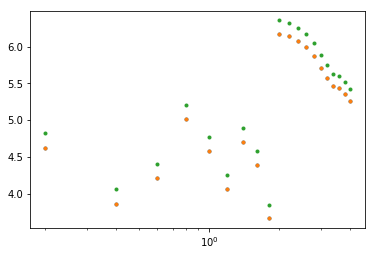

In [25]:
plt.figure()
for i in range(0,len(SM_Beh)):
    plt.semilogx(np.array(z_desired), np.log10(SM_Beh[i]),'.')

In [237]:
print(np.shape(smhm))
print(np.shape(SMHM))
print(SMHM[0,0,0])
#print(z)
#print(z_vdB)

(21, 35, 2)
(21, 35, 2)
-4.494999


In [229]:
def find_HM_idx_vdB(z_idx_vdB, HM_des, HM_vdB):
    for i in range(0, HM_vdB[z_idx_vdB,:].size):
        if (HM_vdB[z_idx_vdB,i]>=HM_des):
            if (i==0):
                HM_idx_vdB = i
                break
            elif (i>0):
                diff1 = np.abs(HM_des-HM_vdB[z_idx_vdB,i-1])
                diff2 = np.abs(HM_des-HM_vdB[z_idx_vdB,i])
                if (diff1<diff2):
                    HM_idx_vdB = i-1
                    break
                elif (diff2<diff1):
                    HM_idx_vdB = i
                    break
    return HM_idx_vdB

In [236]:
z_idx_max = 0
for i in range(0,z.size): #search for z_idx_max in Behroozi, because z_vdB stops at 6, while Behroozi at 10
    if (z[i]>np.max(z_vdB) and z[i-1]<=np.max(z_vdB)):
        z_idx_max=i-1

Mstar_to_be_avaraged = np.zeros(SMHM[0,0,:].size)
HM_desired_z0 = [10., 10.5, 11.]
Mstar = []
for i in HM_desired_z0:
    Mstar.append(np.zeros(z.size))
idx = []
z_idx_vdB = []
for i in range(0, z_idx_max+1):
    for k in range(0,z_vdB.size): #loop to find index in z_vdB
        if (z_vdB[k]>=z[i]):
            if (k==0):
                z_idx_vdB.append(k)
                break
            elif (k>0):
                diff1 = np.abs(z[i]-z_vdB[k-1])
                diff2 = np.abs(z[i]-z_vdB[k])
                if (diff1<diff2):
                    z_idx_vdB.append(k-1)
                    break
                elif (diff2<diff1):
                    z_idx_vdB.append(k)
                    break
                else:
                    Err_msg = 'No index in z_vdB found for the {}th value of z'.format(i)
                    sys.exit(Err_msg)
    #print(i)
    #print(z[i])
    #print(z_vdB[z_idx_vdB[i]])

if (len(z_idx_vdB) != z_idx_max+1):
    print('len(z_idx_vdB) = {}'.format(len(z_idx_vdB)))
    print('z.size = {}'.format(z.size))
    Err_msg = 'Size of z_idx_vdB is different from that of z!'
    sys.exit(Err_msg)

plt.figure()
for j in range(0, z_idx_max+1): #loop on redshifts
    for i in range(0, len(HM_desired_z0)): #loop on HM_z0 desired
        HM_idx_vdB_z0 = find_HM_idx_vdB(z_idx_vdB[0], HM_desired_z0[i], HM_vdB)
        #print(z_idx_vdB[j])
        #print(HM_idx_vdB_z0)
        HM_desired = HM_vdB[j, HM_idx_vdB_z0]
        HM_idx_vdB = find_HM_idx_vdB(z_idx_vdB[j], HM_desired, HM_vdB)
        Mstar_to_be_avaraged = SMHM[j,HM_idx_vdB,1]
        if j == 0:
            print(SMHM[j,HM_idx_vdB,1])
        #Mstar[i][j] =np.median(Mstar_to_be_avaraged)
        #print(j)
        #print(SMHM[j,HM_idx_vdB,:].size)
    #plt.semilogx(z, Mstar[i])
#plt.xlim(0.1,4.)

-4.494999
-4.494999
-4.494956


<Figure size 432x288 with 0 Axes>